# Fit CoFactor model to the binarized ML20M

In [2]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('Agg')

import pandas as pd
from scipy import sparse
#import seaborn as sns
#sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [3]:
import cofacto
import rec_eval

### Construct the positive pairwise mutual information (PPMI) matrix

Change this to wherever you saved the pre-processed data following [this notebook](./preprocess_ML20M.ipynb).

In [4]:
DATA_DIR = '/home/net1/appry001/data/ml-20m/pro'

In [5]:
unique_uid = list()
with open(os.path.join(DATA_DIR, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [6]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print n_users, n_items

111148 11711


In [7]:
def load_data(csv_file, shape=(n_users, n_items)):
    tp = pd.read_csv(csv_file)
    timestamps, rows, cols = np.array(tp['timestamp']), np.array(tp['uid']), np.array(tp['sid'])
    #seq = np.concatenate((rows[:, None], cols[:, None], np.ones((rows.size, 1), dtype='int'), timestamps[:, None]), axis=1)
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=shape)
    return data, _

In [8]:
train_data, train_raw = load_data(os.path.join(DATA_DIR, 'train.csv'))

In [9]:
watches_per_movie = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()

In [10]:
print("The mean (median) watches per movie is %d (%d)" % (watches_per_movie.mean(), np.median(watches_per_movie)))

The mean (median) watches per movie is 597 (48)


In [11]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()

In [12]:
print("The mean (median) movies each user wathced is %d (%d)" % (user_activity.mean(), np.median(user_activity)))

The mean (median) movies each user wathced is 62 (33)


In [13]:
vad_data, vad_raw = load_data(os.path.join(DATA_DIR, 'validation.csv'))

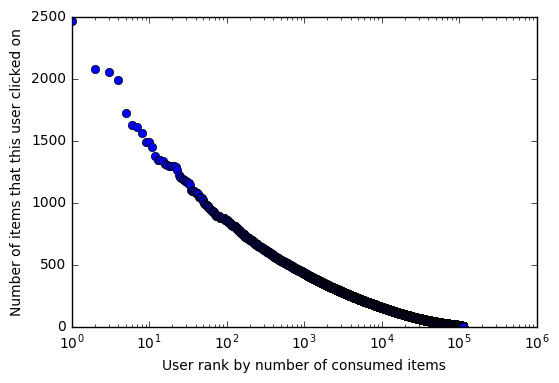

In [14]:
plt.semilogx(1 + np.arange(n_users), -np.sort(-user_activity), 'o')
plt.ylabel('Number of items that this user clicked on')
plt.xlabel('User rank by number of consumed items')
pass

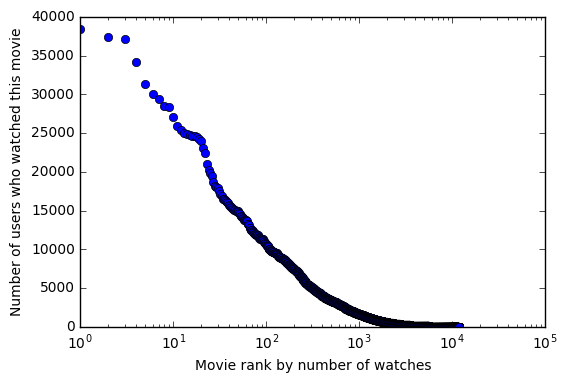

In [15]:
plt.semilogx(1 + np.arange(n_items), -np.sort(-watches_per_movie), 'o')
plt.ylabel('Number of users who watched this movie')
plt.xlabel('Movie rank by number of watches')
pass

### Generate co-occurrence matrix based on the user's entire watching history

In [16]:
def _coord_batch(lo, hi, train_data):
    rows = []
    cols = []
    for u in xrange(lo, hi):
        for w, c in itertools.permutations(train_data[u].nonzero()[1], 2):
            rows.append(w)
            cols.append(c)
    np.save(os.path.join(DATA_DIR, 'coo_%d_%d.npy' % (lo, hi)),
            np.concatenate([np.array(rows)[:, None], np.array(cols)[:, None]], axis=1))
    pass

In [17]:
from joblib import Parallel, delayed

batch_size = 5000

start_idx = range(0, n_users, batch_size)
end_idx = start_idx[1:] + [n_users]

Parallel(n_jobs=8)(delayed(_coord_batch)(lo, hi, train_data) for lo, hi in zip(start_idx, end_idx))
pass

In [18]:
X = sparse.csr_matrix((n_items, n_items), dtype='float32')

for lo, hi in zip(start_idx, end_idx):
    coords = np.load(os.path.join(DATA_DIR, 'coo_%d_%d.npy' % (lo, hi)))
    
    rows = coords[:, 0]
    cols = coords[:, 1]
    
    tmp = sparse.coo_matrix((np.ones_like(rows), (rows, cols)), shape=(n_items, n_items), dtype='float32').tocsr()
    X = X + tmp
    
    print("User %d to %d finished" % (lo, hi))
    sys.stdout.flush()

User 0 to 5000 finished
User 5000 to 10000 finished
User 10000 to 15000 finished
User 15000 to 20000 finished
User 20000 to 25000 finished
User 25000 to 30000 finished
User 30000 to 35000 finished
User 35000 to 40000 finished
User 40000 to 45000 finished
User 45000 to 50000 finished
User 50000 to 55000 finished
User 55000 to 60000 finished
User 60000 to 65000 finished
User 65000 to 70000 finished
User 70000 to 75000 finished
User 75000 to 80000 finished
User 80000 to 85000 finished
User 85000 to 90000 finished
User 90000 to 95000 finished
User 95000 to 100000 finished
User 100000 to 105000 finished
User 105000 to 110000 finished
User 110000 to 111148 finished


Note: Don't forget to delete all the temporary coo_LO_HI.npy files

In [19]:
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_data.npy'), X.data)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indices.npy'), X.indices)
np.save(os.path.join(DATA_DIR, 'coordinate_co_binary_indptr.npy'), X.indptr)

In [20]:
float(X.nnz) / np.prod(X.shape)
# 0.38557504805354814


0.38557504805354814

### Or load the pre-saved co-occurrence matrix

In [21]:
# or co-occurrence matrix from the entire user history
dir_predix = DATA_DIR

In [22]:
data = np.load(os.path.join(dir_predix, 'coordinate_co_binary_data.npy'))
indices = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indices.npy'))
indptr = np.load(os.path.join(dir_predix, 'coordinate_co_binary_indptr.npy'))

In [23]:
X = sparse.csr_matrix((data, indices, indptr), shape=(n_items, n_items))

In [24]:
float(X.nnz) / np.prod(X.shape)

0.38557504805354814

In [25]:
def get_row(Y, i):
    lo, hi = Y.indptr[i], Y.indptr[i + 1]
    return lo, hi, Y.data[lo:hi], Y.indices[lo:hi]

In [26]:
count = np.asarray(X.sum(axis=1)).ravel()

In [27]:
n_pairs = X.data.sum()

### Construct the SPPMI matrix

In [28]:
M = X.copy()

for i in xrange(n_items):
    lo, hi, d, idx = get_row(M, i)
    M.data[lo:hi] = np.log(d * n_pairs / (count[i] * count[idx]))

In [29]:
M.data[M.data < 0] = 0
M.eliminate_zeros()

In [30]:
print float(M.nnz) / np.prod(M.shape)

0.237642385093


Now $M$ is the PPMI matrix. Depending on the number of negative examples $k$, we can obtain the shifted PPMI matrix as $\max(M_{wc} - \log k, 0)$

In [31]:
# number of negative samples
k_ns = 1

M_ns = M.copy()

if k_ns > 1:
    offset = np.log(k_ns)
else:
    offset = 0.
    
M_ns.data -= offset
M_ns.data[M_ns.data < 0] = 0
M_ns.eliminate_zeros()

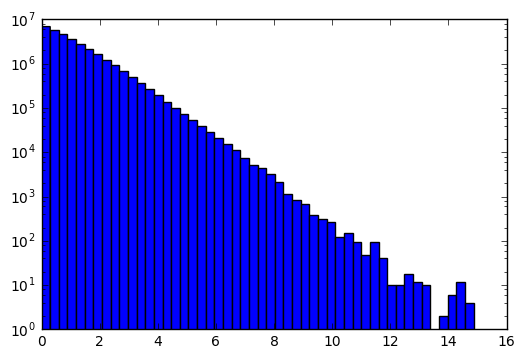

In [32]:
plt.hist(M_ns.data, bins=50)
plt.yscale('log')
pass

In [33]:
float(M_ns.nnz) / np.prod(M_ns.shape)

0.23764238509276445

### Train the model

In [34]:
scale = 0.03

n_components = 100
max_iter = 20
n_jobs = 8
lam_theta = lam_beta = 1e-5 * scale
lam_gamma = 1e-5
c0 = 1. * scale
c1 = 10. * scale

save_dir = os.path.join(DATA_DIR, 'ML20M_ns%d_scale%1.2E' % (k_ns, scale))

In [35]:
reload(cofacto)
coder = cofacto.CoFacto(n_components=n_components, max_iter=max_iter, batch_size=1000, init_std=0.01, n_jobs=n_jobs, 
                        random_state=98765, save_params=True, save_dir=save_dir, early_stopping=True, verbose=True, 
                        lam_theta=lam_theta, lam_beta=lam_beta, lam_gamma=lam_gamma, c0=c0, c1=c1)

In [36]:
coder.fit(train_data, M_ns, vad_data=vad_data, batch_users=5000, k=100)

ITERATION #0
	Updating user factors: time=16.32
	Updating item factors: time=6.13
	Updating context factors: time=3.31
	Updating bias terms: time=3.60


rec_eval.py:257: RuntimeWarning: invalid value encountered in divide
  return DCG / IDCG


	Validation NDCG@k: 0.19163
ITERATION #1
	Updating user factors: time=16.79
	Updating item factors: time=5.67
	Updating context factors: time=3.51
	Updating bias terms: time=3.65
	Validation NDCG@k: 0.26963
ITERATION #2
	Updating user factors: time=17.58
	Updating item factors: time=5.72
	Updating context factors: time=3.40
	Updating bias terms: time=3.80
	Validation NDCG@k: 0.34485
ITERATION #3
	Updating user factors: time=17.58
	Updating item factors: time=5.77
	Updating context factors: time=3.20
	Updating bias terms: time=3.43
	Validation NDCG@k: 0.35849
ITERATION #4
	Updating user factors: time=17.32
	Updating item factors: time=6.24
	Updating context factors: time=3.50
	Updating bias terms: time=3.70
	Validation NDCG@k: 0.36298
ITERATION #5
	Updating user factors: time=17.75
	Updating item factors: time=5.86
	Updating context factors: time=3.47
	Updating bias terms: time=3.71
	Validation NDCG@k: 0.36325
ITERATION #6
	Updating user factors: time=17.55
	Updating item factors: time=

CoFacto(batch_size=1000, dtype='float32', early_stopping=True, init_std=0.01,
    max_iter=20, n_components=100, n_jobs=8, random_state=98765,
    save_dir='/home/net1/appry001/data/ml-20m/pro/ML20M_ns1_scale3.00E-02',
    save_params=True, verbose=True)

In [37]:
test_data, _ = load_data(os.path.join(DATA_DIR, 'test.csv'))
test_data.data = np.ones_like(test_data.data)

In [38]:
n_params = len(glob.glob(os.path.join(save_dir, '*.npz')))

params = np.load(os.path.join(save_dir, 'CoFacto_K%d_iter%d.npz' % (n_components, n_params - 1)))
U, V = params['U'], params['V']

In [39]:
print 'Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, vad_data=vad_data)
print 'Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, vad_data=vad_data)
print 'Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data)
print 'Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data)

rec_eval.py:184: RuntimeWarning: invalid value encountered in divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


Test Recall@20: 0.1448
Test Recall@50: 0.1765
Test NDCG@100: 0.1724
Test MAP@100: 0.0545


In [40]:
np.savez('CoFactor_K100_ML20M.npz', U=U, V=V)